## Step 1 :-  Loading necessary libraries for Analysis 

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import *
from keras.callbacks import *

Using TensorFlow backend.


## Step 2 :- Data load 
<div class="alert alert-block alert-success">
<b>We will be using the Amazon stock price data from Jan 1, 2006 to Jan 1, 2018</b> 
    <br>
The folder contains datasets related to various stock prices of different firms and from there we are going to pick up the Fourth dataset which will be the dataset we are going to use for analysis.
</div>

In [2]:
path                = r'D:\kaggle_trials\stock_time_series_data_dija'
relevant_data_files = os.listdir(path)
stock_data_path     = path+'\\'+relevant_data_files[4]
df                  = pd.read_csv(stock_data_path)
df.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


## Step 3 :- Extracting Features from the data
<div class="alert alert-block alert-success">
<b>Extracting the Closing price of the stock </b> 
    <br>
We are going to work with the closing price of the stock and hence we are going to extract the 'Close' column of the dataframe loaded. The dataset is already sorted and hence we don't need to perform any ordering on the dataset
</div>

In [3]:
sub_data_needed      = df.iloc[:,4:5]
print('The length of the sub data(containing only the closing stock prices) we have is:- ', len(sub_data_needed))
sub_data_needed.head(3)

The length of the sub data(containing only the closing stock prices) we have is:-  3019


,Close
0,47.58
1,47.25
2,47.65


## Step 4:- Separating the Train and Validation data
<div class="alert alert-block alert-success">
We are going to use the first 2500 dataset values for training the RNN model and the remaining 519 values to check the validity of the model.
</div>

In [4]:
training_set = sub_data_needed.iloc[:2500,:].values
print('The size of training set is:- ',len(training_set))

The size of training set is:-  2500


## Step 5:- Preprocessing Training Data 
<div class="alert alert-block alert-success">
<b>Min-Max Normalization technique </b> 
    <br>
1. We will <b> normalize the training dataset</b> <br>
2.  We will arrange the <b> one dimensional dataset to a two dimensional dataset </b> where each row will consist of 90 timesteps to predict 1 output and we will have a 2 dimensional data having (2500-90) = 2410 rows and 60 columns. 
3. We will also store the 61st observation corresponding to every row in a separate array to be used for testing in an LSTM model.<br>
4. The input of the LSTM model is a 3D tensor with shape (batch_size, timesteps, input_dim). <br>
    <b> In our case, batch size is 2410, timesteps is 90 and input_dim = 1 as we are only considering the closing prices </b>
</div>

In [5]:
time_dep            = 90
sc                  = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

X_train             = []
y_train             = []
for i in range(time_dep, 2500):
    X_train.append(training_set_scaled[i-time_dep:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train    = np.array(X_train), np.array(y_train)

X_train             = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('We get the Training data X of shape :- ',X_train.shape)
print('We get the test data of shape       :- ',y_train.shape)
print('We can clearly see that corresponding to each set of 90 timesteps, we have one value to predict')

We get the Training data X of shape :-  (2410, 90, 1)
We get the test data of shape       :-  (2410,)
We can clearly see that corresponding to each set of 90 timesteps, we have one value to predict


## Step 6 : Callback Creation
We create callbacks which we will be using while execution of the model

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.0001)
es        = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='auto', baseline=None, 
                          restore_best_weights=True)
filepath   = os.getcwd()+'\\chkpts\\'+"weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## Step 7 : Building the actual model 
<div class="alert alert-block alert-success">
<b>LSTM + Dense layers </b> 
    <br>
1. We will fit an <b> LSTM model having 3 layers</b> <br>
2. We will then get the outcome of the LSTM layers to one dense layer having 100 hidden layers whose outcome will go to one final layer

In [7]:
model = Sequential()
model.add(LSTM(units=500,return_sequences=True,activation='tanh',input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.15))
model.add(LSTM(units=380,return_sequences=True,activation = 'tanh'))
model.add(Dropout(0.15))
model.add(LSTM(units=260))
model.add(Dropout(0.15))
model.add(Dense(units = 100))
model.add(Dropout(0.1))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 500)           1004000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 500)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 380)           1339120   
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 380)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 260)               666640    
_________________________________________________________________
dropout_3 (Dropout)  

## Step 8 :- Fitting the model
We will fit the model with fixed epochs and batch-size

In [8]:
epochs = 40
batch_sz = 24
model.fit(X_train, y_train, 
          epochs = epochs, 
          batch_size = batch_sz,
         callbacks        = [reduce_lr,es,checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
2410/2410 [==============================] - 39s 16ms/step - loss: 0.0085

Epoch 00001: loss improved from inf to 0.00848, saving model to C:\Users\Batfleck\APB_DL_EXERCISES\Stock_price_prediction_lstm\chkpts\weights-improvement-01-0.01.hdf5
Epoch 2/40
2410/2410 [==============================] - 35s 14ms/step - loss: 8.9926e-04

Epoch 00002: loss improved from 0.00848 to 0.00090, saving model to C:\Users\Batfleck\APB_DL_EXERCISES\Stock_price_prediction_lstm\chkpts\weights-improvement-02-0.00.hdf5
Epoch 3/40
2410/2410 [==============================] - 35s 15ms/step - loss: 7.6469e-04

Epoch 00003: loss improved from 0.00090 to 0.00076, saving model to C:\Users\Batfleck\APB_DL_EXERCISES\Stock_price_prediction_lstm\chkpts\weights-improvement-03-0.00.hdf5
Epoch 4/40
2410/2410 [==============================] - 35s 15ms/step - loss: 6.8857e-04

Epoch 00004: loss improved from 0.00076 to 0.00069, saving model to C:\Users\Batfleck\A

## Step 9 :- Validating the model
We will now validate the model on a given sequence of stock prices. 
<div class="alert alert-block alert-success">
<b>Validation </b> 
    <br>
1. We will validate the data on the last 519 observations.  <br>
2. We will adjust our data accordingly to get the test data in accordance with the input format needed by the LSTM model that we fitted in step 7 
</div>

In [9]:
dataset_test         = sub_data_needed.iloc[2500:,:]
real_stock_price     = dataset_test.values
inputs = sub_data_needed[len(sub_data_needed)-len(dataset_test)-time_dep:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_dep, time_dep+len(dataset_test)):
    X_test.append(inputs[i-time_dep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Step 10 :- Performance metrics and Graphical representation

In [10]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('The R2 score between the predicted and actual values is: ',round(r2_score(real_stock_price,predicted_stock_price),3))

The R2 score between the predicted and actual values is:  0.984


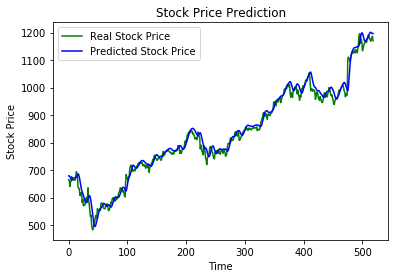

In [12]:
plt.plot(real_stock_price, color = 'green', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
